# Controllable GAN

Using gradients from a classifier. We train a classifier to recognize a relevant feature, we use this to control the z-vectors

### CelebA dataset 

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
torch.manual_seed(0)


In [2]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise): # (n_samples, z_dim)  n_samples - no of noise vectors we want to generate | z_dim - dim of each noise vector
        
        x = noise.view(len(noise), self.z_dim, 1, 1) # batch_size, no of features - z_dim, height, width
        return self.gen(x)

In [4]:
# initlializing the noise
def get_noise(n_samples, z_dim, device='cpu'):
    
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
class Classifier(nn.Module):

    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        # extracting the relevant features from the image
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if final_layer: # no Activations, as we need raw output
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        # for non-final layers
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True), # to take the positive and negative effects
            )

    def forward(self, image):
        
        class_pred = self.classifier(image) # (batch_size, n_classes, height,width) - returned
        # reshaping 
        return class_pred.view(len(class_pred), -1) # (batch_size, -1) - falttens

## Parameters

In [6]:
z_dim = 64
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def train_classifier(filename):
    from torchvision import transforms
    # defines a range of label indices
    label_indices = range(40) # total number of classes

    n_epochs = 3
    display_step = 500
    lr = 0.001
    # parameters of Adam Optimizer
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    # instance of classifier
    classifier = Classifier(n_classes=len(label_indices)).to(device)

    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    classifier_val_losses = []
    
    for epoch in range(n_epochs):
        # dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels) # loss

            class_loss.backward() # gradients calculating
            class_opt.step() # updating

            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Epoch {epoch}, step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1
 
# train_classifier()

In [8]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("Model_CGAN/pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("Model_CGAN/pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


In [9]:
# update the noise to produce more of your desires feature. We perform Stochastic Gradient Ascent to find the local maxima
# Gradient Ascent is gradient descent over the negative of the value being optimized, we calculate the gradient ascent 
def calculate_updated_noise(noise, weight):
    # we use SGA to try and maximize the amount of the feature we want
    new_noise = noise + weight * noise.grad

    return new_noise

# if we want to reduce the amount of the feature, we apply gradient descent.

## Generation

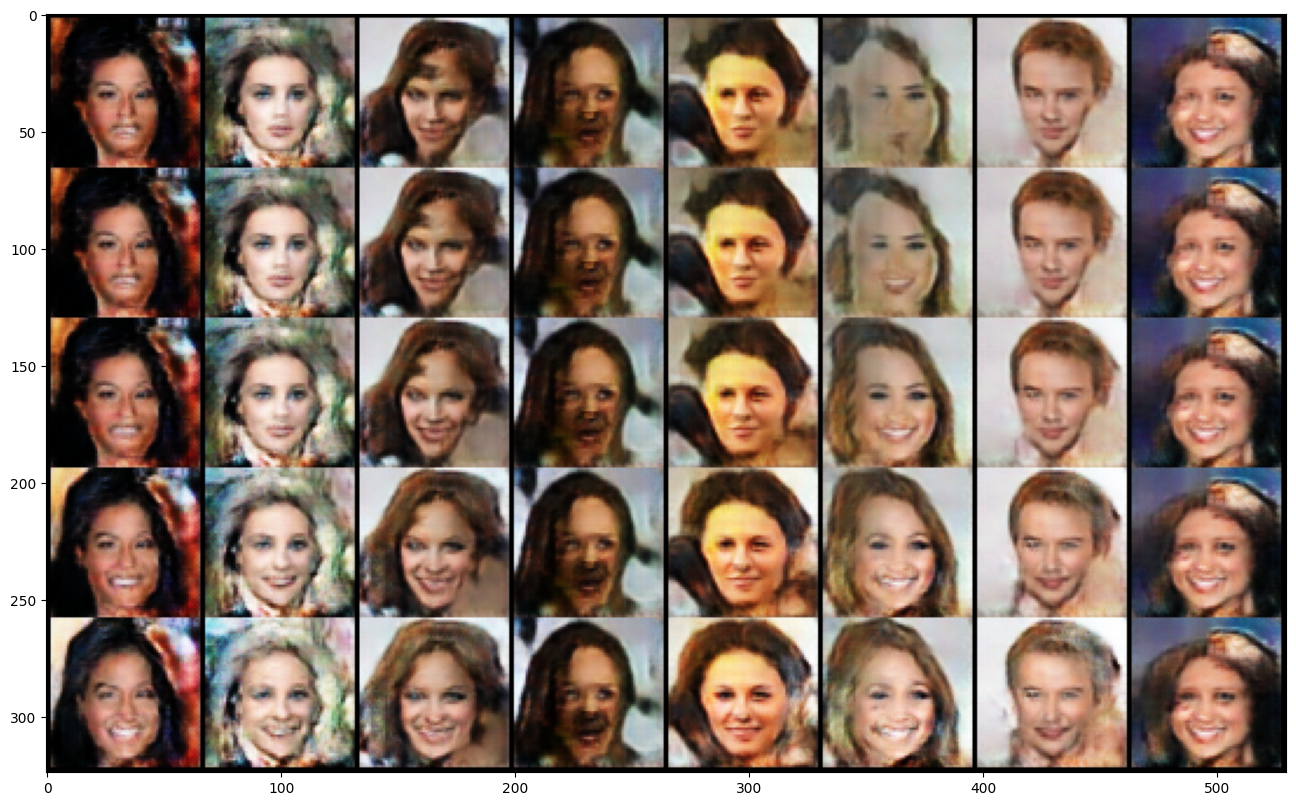

In [19]:
# generating images with generator
n_images = 8
fake_image_history = []
grad_steps = 10 # no of gradient steps to take
skip = 2 # no of gradient steps to skip in the visualization


feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Smiling") # choosing a class

# initlialization
noise = get_noise(n_images, z_dim).to(device).requires_grad_()

for i in range(grad_steps):# performing grad ascent for grad_step iterations
    opt.zero_grad() # clears the grad 
    fake = gen(noise) # generate fake images 
    fake_image_history += [fake] # for visualization
    # computing the mean score. Computes the 
    # classifier computes a set of class scores for each generated image. (n_images, n_classes) - we take only a specified
    fake_classes_score = classifier(fake)[:, target_indices].mean() # computes the mean score of the selected class
    fake_classes_score.backward() # backprop
    noise.data = calculate_updated_noise(noise, 1 / grad_steps) # updates the noise vecotr

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2] # size of the resulting plot, width and height
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

Entanglement in GANs refers to the situation where multiple features or attributes in the generated data are closely connected or interdependent. Regularization to prevent it from overfitting the training data. Used to reduce entanglement and ensure that changes in one feature do not sigificantly affect other features

### Entanglement and Regularization

Sometimes, more features than jut the target feature change. Because, some features are entangled. To fix, we try to isolate the target feature more by holding the classes outside of the target class constant.

In [20]:
'''
We can implement this by penalizing the differences from the original class with L2 regularization. 
'''
# Higher the score, better it is.. The score is calculated by adding the target score and a penalty, penalty is meant to lower the score, so it should have a negative value

'\nWe can implement this by penalizing the differences from the original class with L2 regularization. \n'

In [21]:
# for every non-target class, take the difference between the current noise and the old noise. The greater the values is, the more features outside the target have changed.
# take the magnitude of the change, take the mean and negate it. then, add this penalty to the target score
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class for which you want to emphasize the feature
        other_indices: the indices of the other classes for which we want to minimize the changes in 
        penalty_weight: the amount that the penalty should be weighted in the overall score -- for regularization
    '''
    # calulcating the change in other classes
    # calculating  the error on other indices     # how much the classifications have changed for the classes outside the target class
    other_distances = current_classifications[:,other_indices] - original_classifications[:,other_indices] # each row corresponds to an example and each column corresponds to a class in 'other indices'
    # calculate the norm (magnitude) of changes per class and multiply by penalty weight
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight # L2 norm / Euclidean norm - discourages changes in class outisde the target class. higher the penalty weight, the stronger the penalty
    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean() # to check how well the generated data matches the target class
    return target_score + other_class_penalty
# how wel the generated data matches the target class while discouraging changes outisde the target class using norm based penalty

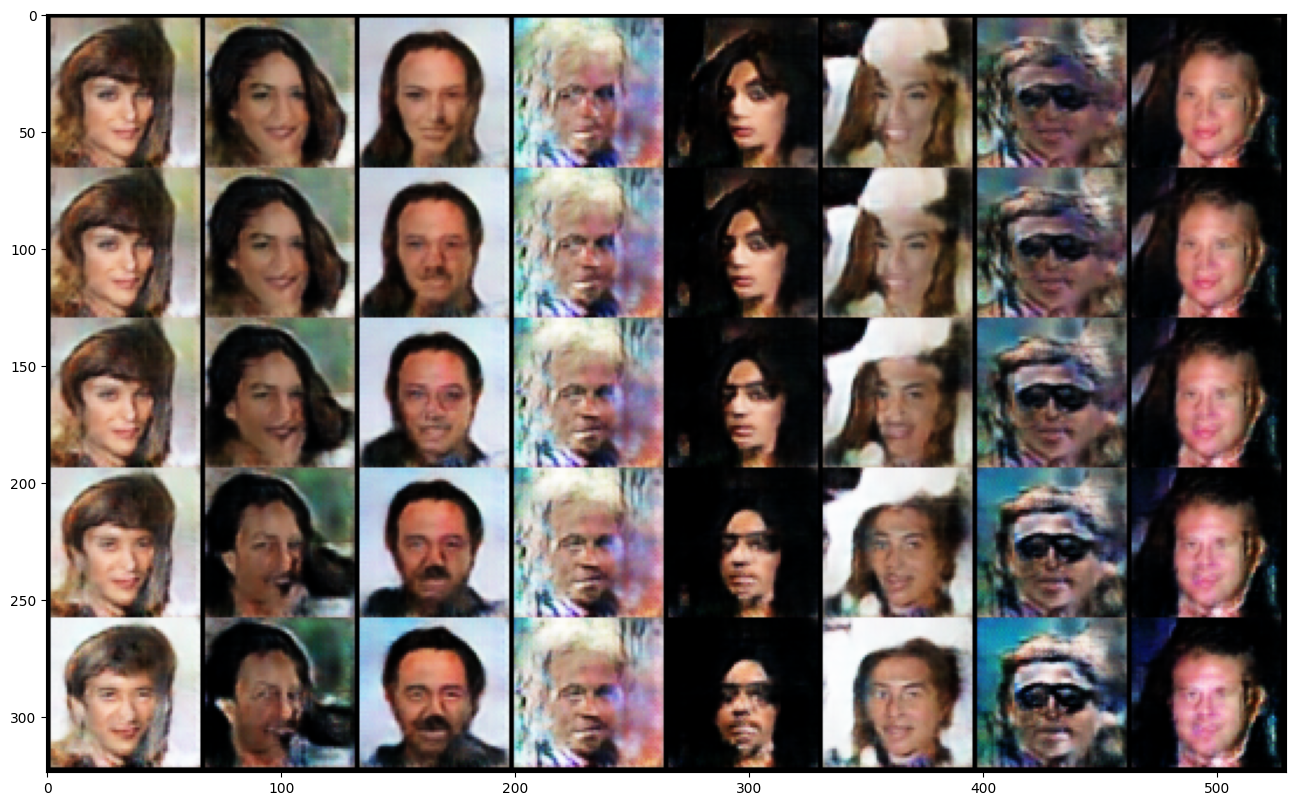

In [25]:
fake_image_history = []

target_indices = feature_names.index("Male") 
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach() # this will not be updated in the training
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)